# Mood Prediction Using Smartphone Data
### Data Mining Techniques | Vrije Universiteit Amsterdam | April 2024
##### Lieve Jilesen (ljn278), Ryan Ott (rot280), and Jaime Perez y Perez (jpz240) | Group 17

## 1 - Data Preparation

### 1.1 - Exploratory Data Analysis

#### Importing packages & loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# sns.set(style="whitegrid")
# import statsmodels.api as sm

file_path = 'data/dataset_mood_smartphone.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col=0)
df

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


#### General data properties

In [2]:
num_records = df.shape[0]
num_participants = df.id.nunique()
num_days = df.time.dt.date.nunique()
num_variables = df.variable.nunique()

data_characteristics = {
    "Number of Records": [num_records],
    "Number of Participants": [num_participants],
    "Number of Days": [num_days],
    "Number of Variables": [num_variables],
}

data_characteristics_df = pd.DataFrame(data_characteristics)
data_characteristics_df

,Number of Records,Number of Participants,Number of Days,Number of Variables
0,376912,27,113,19


#### Variable properties

In [3]:
def create_summary_df(df):
    # Create a summary table for the dataset
    summary_data = {
        "Variable": [],
        "Data Type": [],
        "Total Records": [],
        "Unique Values": [],
        "Missing Values": [],
        "Mean": [],
        "Std": [],
        "Min": [],
        "25%": [],
        "50%": [],
        "75%": [],
        "Max": []
    }

    for var in df.variable.unique():
        var_data = df[df['variable'] == var]['value']
        desc = var_data.describe()
        summary_data["Variable"].append(var)
        summary_data["Data Type"].append(df[df['variable'] == var]['value'].dtype)
        summary_data["Total Records"].append(var_data.count())
        summary_data["Unique Values"].append(var_data.nunique())
        summary_data["Missing Values"].append(df[df['variable'] == var]['value'].isnull().sum())
        summary_data["Mean"].append(desc['mean'])
        summary_data["Std"].append(desc['std'])
        summary_data["Min"].append(desc['min'])
        summary_data["25%"].append(desc['25%'])
        summary_data["50%"].append(desc['50%'])
        summary_data["75%"].append(desc['75%'])
        summary_data["Max"].append(desc['max'])

    return pd.DataFrame(summary_data)

In [4]:
summary_df = create_summary_df(df)
summary_df

,Variable,Data Type,Total Records,Unique Values,Missing Values,Mean,Std,Min,25%,50%,75%,Max
0,mood,float64,5641,10,0,6.992555,1.032769,1.000,7.00000,7.000000,8.000000,10.000
1,circumplex.arousal,float64,5597,5,46,-0.098624,1.051868,-2.000,-1.00000,0.000000,1.000000,2.000
2,circumplex.valence,float64,5487,5,156,0.687808,0.671298,-2.000,0.00000,1.000000,1.000000,2.000
3,activity,float64,22965,1868,0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
4,screen,float64,96578,64646,0,75.335206,253.822497,0.035,5.32225,20.044500,62.540250,9867.007
5,call,float64,5239,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
6,sms,float64,1798,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
7,appCat.builtin,float64,91288,23237,0,18.538262,415.989243,-82798.871,2.02000,4.038000,9.922000,33960.246
8,appCat.communication,float64,74276,39890,0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
9,appCat.entertainment,float64,27125,12575,0,37.576480,262.960476,-0.011,1.33400,3.391000,14.922000,32148.677


#### Any records missing id or time?

In [5]:
# Do we have any records without index, id or time?
df[df['id'].isnull() | df['time'].isnull()]

,id,time,variable,value


No, thankfully not.

#### Distribution of variable values

In [6]:
def plot_vars_dist(df):
    variables = [var for var in df['variable'].unique() if var not in ['sms', 'call']]  # ignoring these as they are only 1 value indicating occurence of a call/sms
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 6 * len(variables)))

    for ax, var in zip(axes.flatten(), variables):
        var_data = df[df['variable'] == var]['value'].dropna()
        mean = var_data.mean()
        std = var_data.std()
        # Adjust bins for better visualization based on data range and characteristics
        bins = min(30, int(var_data.nunique()))  # Use a minimum of 30 bins or less if fewer unique values

        ax.hist(var_data, bins=bins, alpha=0.75, color='blue', edgecolor='black', label=f'{var} Scores')
        ax.set_title(f'Distribution of {var} values')
        ax.set_xlabel(f'{var.capitalize()} Score')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.75)
        legend_label = f"Mean: {mean:.2f}, Std: {std:.2f}"
        ax.legend([f"{var.capitalize()} Scores\n{legend_label}"], loc='upper right', title='Statistics', frameon=True)

    plt.tight_layout()
    plt.show()

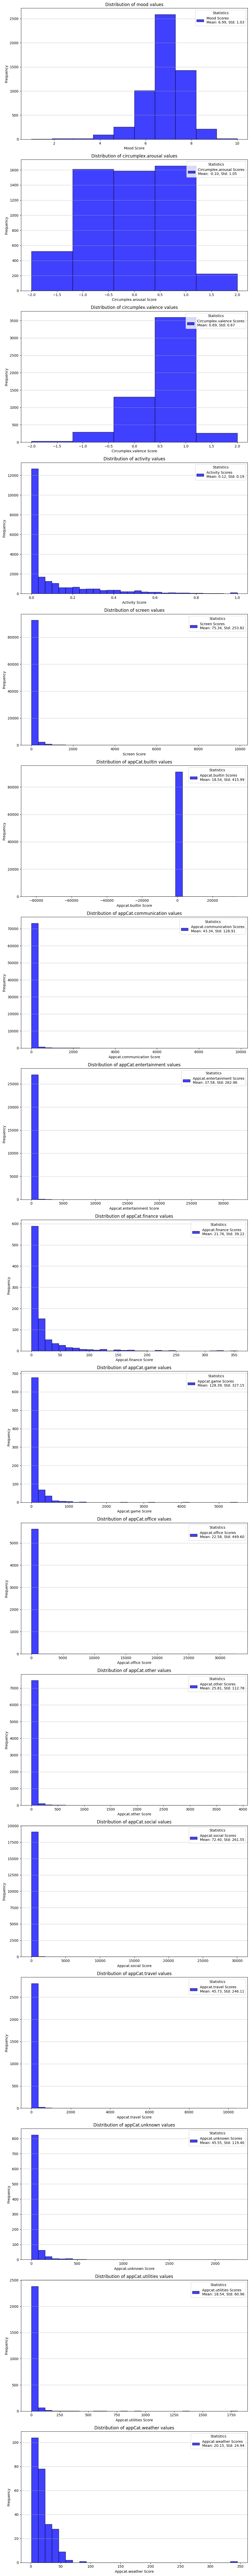

In [7]:
plot_vars_dist(df)

Histograms showing the distribution of possible values for the different (non-boolean) variables in our dataset. The mood, valence and arousal of participants seems to be normally distributed with different means and variances. All other variables seem to perhaps follow an exponential distribution, with most mass close to 0 and decreasing number of records with higher values. We do also see outliers present in the exponentially distributed data.

#### Mood for a participant

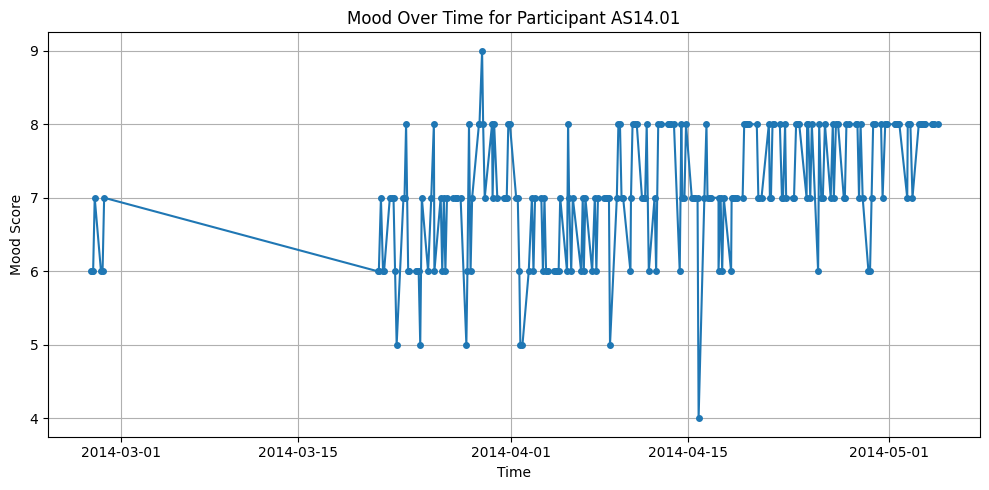

In [8]:
# Time Series of Mood for a Selected Participant
participant_data = df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')]
plt.figure(figsize=(10, 5))
plt.plot(participant_data['time'], participant_data['value'], marker='o', markersize=4, linestyle='-')
plt.title('Mood Over Time for Participant AS14.01')
plt.xlabel('Time')
plt.ylabel('Mood Score')
plt.xticks()
plt.grid()
plt.tight_layout()
plt.show()

Timeseries plot of the mood scores given by the first participant. We see it being around 7 +- 1 for most of the time, with rare moments of more extreme emotions. We also see long gaps in the record availability.

#### Correlation map for variables with mood

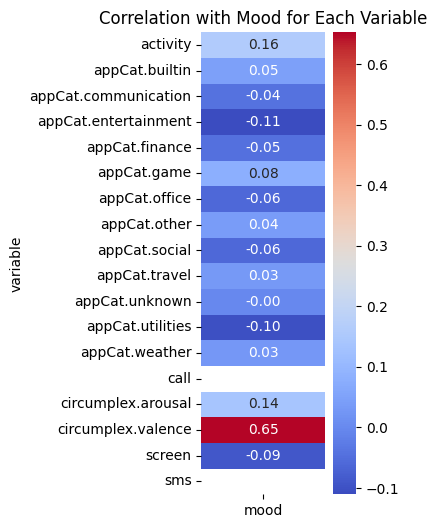

In [9]:
data = df.groupby(['id', 'variable', df['time'].dt.date])['value'].mean()
data = data.reset_index()
data['value'] = data['value'].astype(float)
data['time'] = data['time'].astype("string")
data.loc[data['variable'] == 'mood', 'value'] = np.round(data.loc[data['variable'] == 'mood', 'value'])

# Create pivot table
pivot_table = data.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='mean')
correlation_matrix = pivot_table.corr()

# Filter to only show correlations of all variables with 'mood'
mood_correlations = correlation_matrix[['mood']].drop(index='mood')

# Plot the heatmap
plt.figure(figsize=(2, 6))
sns.heatmap(mood_correlations, annot=True, fmt=".2f", cmap='coolwarm', vmin=mood_correlations.min(), vmax=mood_correlations.max())
plt.title('Correlation with Mood for Each Variable')
plt.xlabel('')
plt.show()

In [10]:
#*** OLD NOT USED ***
# Correlation heatmap of variables
# data = df.groupby(['id','variable',df['time'].dt.date])['value'].mean()
# data = data.reset_index()
# data['value'] = data['value'].astype(float)
# data['time'] = data['time'].astype("string")
# data.loc[data['variable'] == 'mood', 'value'] = np.round(data.loc[data['variable'] == 'mood', 'value'])

# pivot_table = data.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='mean')
# correlation_matrix = pivot_table.corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Heatmap of Variables')
# plt.show()

The heatmap of correlation of all variables with mood, providing a color-coded representation of the correlation values, with warmer colors indicating stronger positive correlations and cooler colors indicating stronger negative correlations. (`call` and `sms` are not visible as they are only recorded when a call takes place so it always has a value of 1).
Valence especially seems to be highly positively corellated with mood, while using entertainment apps for longer seems to correlate most negatively with mood. These could be valuable insights into predicting the mood for participants based on usage behaviour.

#### Activity & mood relationship

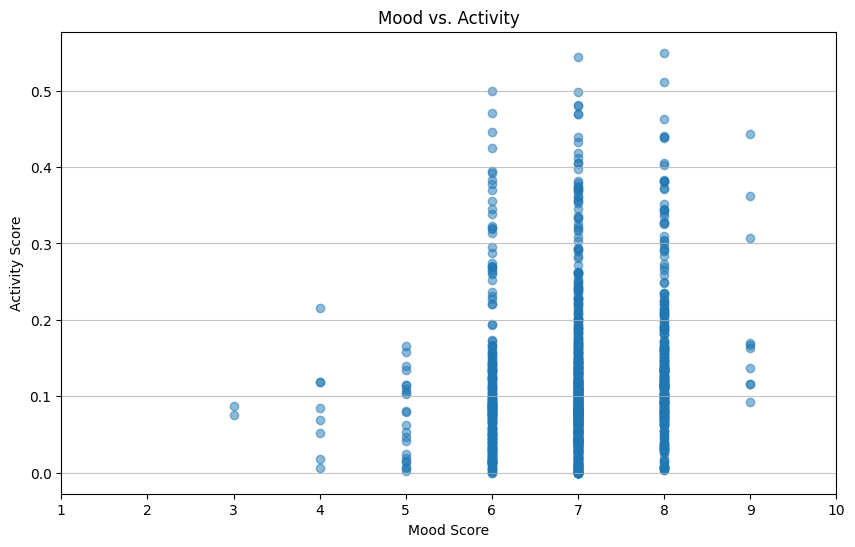

In [11]:
# Activity and Mood Relationship
activity_data = data[data['variable'] == 'activity']
mood_data = data[data['variable'] == 'mood']

# Merging on ID and Time for direct comparison
activity_mood_merged = pd.merge(activity_data, mood_data, on=['id', 'time'], suffixes=('_activity', '_mood'))

plt.figure(figsize=(10, 6))
plt.scatter(activity_mood_merged['value_mood'], activity_mood_merged['value_activity'], alpha=0.5)
plt.title('Mood vs. Activity')
plt.xlabel('Mood Score')
plt.ylabel('Activity Score')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.75)
plt.show()

Plot showing co-occurence of mood with activiy scores for all participants. If the mood is in the common range of 7±1 we see participants record a wide range of activity scores, while if the mood is low, there is no high activity. 

### 1.2 - Data Cleaning

#### Adapting datatypes

Because call and sms are boolean (only present if true) we convert them to boolean values.

In [12]:
# Convert 'call' and 'sms' data to boolean - !! Removed for now because it impacts performance negatively
# for variable in ['call', 'sms']:
#     df.loc[df['variable'] == variable, 'value'] = df[df['variable'] == variable]['value'].fillna(0).astype(bool)

#### Removing incorrect values

Because all `appCat.*` variables and `screen` should denote a time duration, they cannot be negative. Thus, any records with negative duration must be incorrect and removed. We see this is the case for example when looking at the variables properties table under section 1.1, where the min value for `appCat.builtin` is highly negative.

In [13]:
# List of variables denoting time durations
time_variables = [var for var in df['variable'].unique() if 'appCat.' in var or var == 'screen']

# Remove records with negative durations for time variables
print("Removed records due to negative values:")
initial_count = df.shape[0]
for var in time_variables:
    before_count = df[df['variable'] == var].shape[0]
    df = df[~((df['variable'] == var) & (df['value'] < 0))]
    after_count = df[df['variable'] == var].shape[0]
    print(f"{before_count - after_count} from {var}")

total_removed = initial_count - df.shape[0]
print(f"Total records removed: {total_removed}")

Removed records due to negative values:
0 from screen
3 from appCat.builtin
0 from appCat.communication
1 from appCat.entertainment
0 from appCat.finance
0 from appCat.game
0 from appCat.office
0 from appCat.other
0 from appCat.social
0 from appCat.travel
0 from appCat.unknown
0 from appCat.utilities
0 from appCat.weather
Total records removed: 4


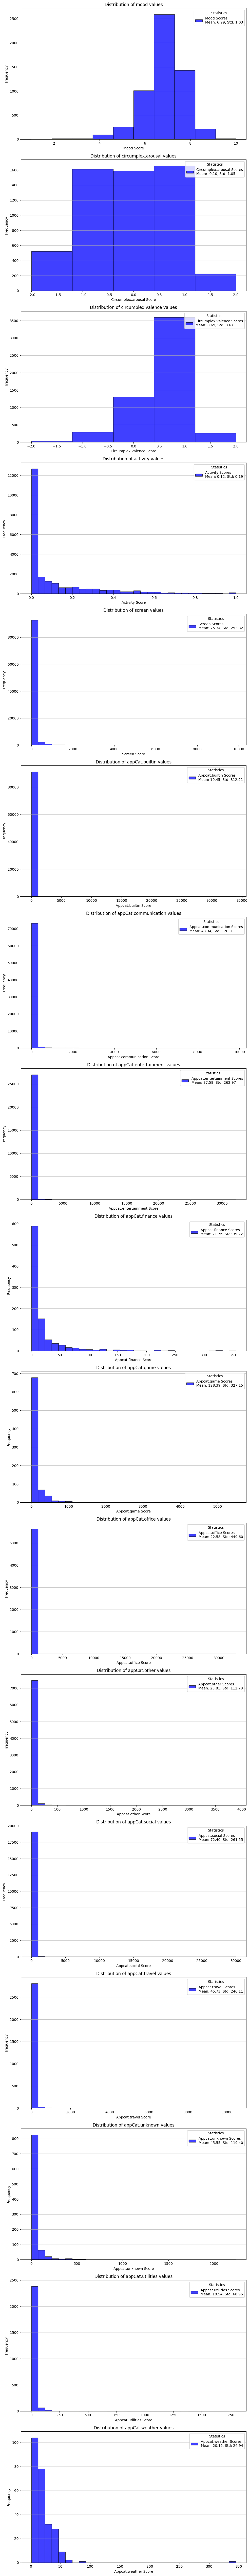

In [14]:
plot_vars_dist(df)

#### Removing extreme values

For numeric variables that are not self-reported by the participants (so not `mood`, `arousal`, `valence`, & `activity`, and also not `call` or `SMS`) we remove values that lie outside of the interquartile range (IQR). To do this, we first calculate the IQR, which is the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data. Values that fall below $Q1 - 1.5 * IQR$ or above $Q3 + 1.5 * IQR$ are considered outliers and are thus excluded from the analysis to prevent them from skewing the results. Its better suited for this scenario because unlike using the z-score method for example, this method doesn't necessarily assume an underlying normal distribution.

In [15]:
# Outlier removal using the Interquartile Range (IQR) method
def remove_iqr_outliers(df, variable, iqr_range=1.5):  # set iqr_range to higher to exclude fewer
    # Filter the dataset for a specific variable
    filter_df = df[df['variable'] == variable]
    Q1 = filter_df['value'].quantile(0.25)
    Q3 = filter_df['value'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - iqr_range * IQR
    upper_bound = Q3 + iqr_range * IQR

    # Filtering out outliers
    before_removal = filter_df.shape[0]
    filtered_df = filter_df[(filter_df['value'] >= lower_bound) & (filter_df['value'] <= upper_bound)]
    after_removal = filtered_df.shape[0]

    print(f'{before_removal - after_removal} outliers from {variable}')
    return df[(df['variable'] != variable) | ((df['value'] >= lower_bound) & (df['value'] <= upper_bound))]

In [16]:
# Variables for which we remove outliers
# store the count of each variable in a dict
exclude_vars = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'call', 'sms']
outlier_vars = [var for var in df['variable'].unique() if var not in exclude_vars]

print('Removed outliers using IQR method:')
initial_count = df.shape[0]
for var in outlier_vars:
    df = remove_iqr_outliers(df, var)
total_removed = initial_count - df.shape[0]
print(f"Total records removed: {total_removed}")

Removed outliers using IQR method:
10055 outliers from screen
10150 outliers from appCat.builtin
6401 outliers from appCat.communication
4517 outliers from appCat.entertainment
118 outliers from appCat.finance
85 outliers from appCat.game
848 outliers from appCat.office
1000 outliers from appCat.other
1838 outliers from appCat.social
181 outliers from appCat.travel
80 outliers from appCat.unknown
182 outliers from appCat.utilities
10 outliers from appCat.weather
Total records removed: 35465


In [17]:
summary_df = create_summary_df(df)
summary_df

,Variable,Data Type,Total Records,Unique Values,Missing Values,Mean,Std,Min,25%,50%,75%,Max
0,mood,float64,5641,10,0,6.992555,1.032769,1.000,7.00000,7.000000,8.000000,10.000
1,circumplex.arousal,float64,5597,5,46,-0.098624,1.051868,-2.000,-1.00000,0.000000,1.000000,2.000
2,circumplex.valence,float64,5487,5,156,0.687808,0.671298,-2.000,0.00000,1.000000,1.000000,2.000
3,activity,float64,22965,1868,0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
4,screen,float64,86523,54685,0,29.914995,33.657583,0.035,5.20100,15.514000,43.122500,148.350
5,call,float64,5239,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
6,sms,float64,1798,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
7,appCat.builtin,float64,81135,14334,0,5.208883,4.571340,0.001,2.00800,3.665000,7.015500,21.764
8,appCat.communication,float64,67875,33604,0,23.674507,24.677206,0.006,5.09550,13.321000,34.969500,105.855
9,appCat.entertainment,float64,22607,8234,0,5.325442,6.822312,0.001,1.07350,2.405000,6.038000,35.293


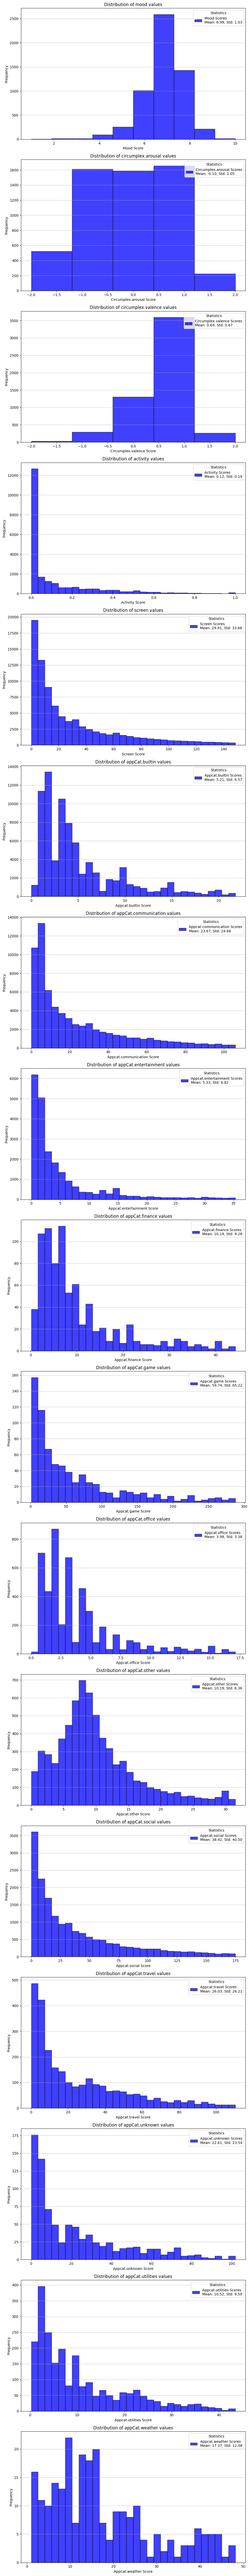

In [18]:
plot_vars_dist(df)

When comparing the histograms with those created before the cleaning, we no longer have few very high frequency bins and small bins extremely far away.

#### Imputing missing values

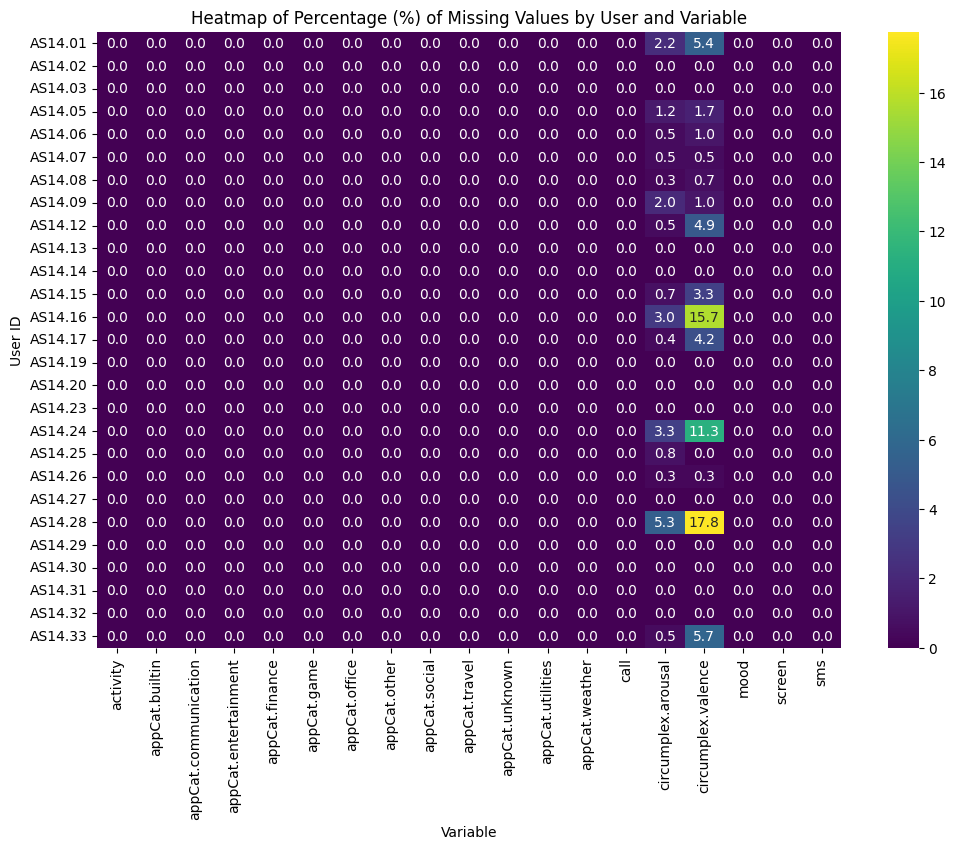

In [19]:
# Group the data by 'id' and 'variable' and count NaN values for each grouping
nan_counts = df.groupby(['id', 'variable']).apply(lambda x: x['value'].isnull().sum()).reset_index(name='Missing Values')

# Determine the total possible records for each user-variable combination
total_possible_records = df.groupby(['id', 'variable']).size().reset_index(name='Total Records')

# Merge the count of NaN values with the total possible records to calculate percentages
merged_counts = pd.merge(nan_counts, total_possible_records, on=['id', 'variable'])
merged_counts['Missing Percentage'] = (merged_counts['Missing Values'] / merged_counts['Total Records']) * 100

# Pivot the results to show the percentage of missing values: users on rows, variables on columns
nan_percentage_pivot = merged_counts.pivot(index='id', columns='variable', values='Missing Percentage').fillna(0)

# Plotting the heatmap of missing value percentages
plt.figure(figsize=(12, 8))
sns.heatmap(nan_percentage_pivot, annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap of Percentage (%) of Missing Values by User and Variable')
plt.xlabel('Variable')
plt.ylabel('User ID')
plt.show()

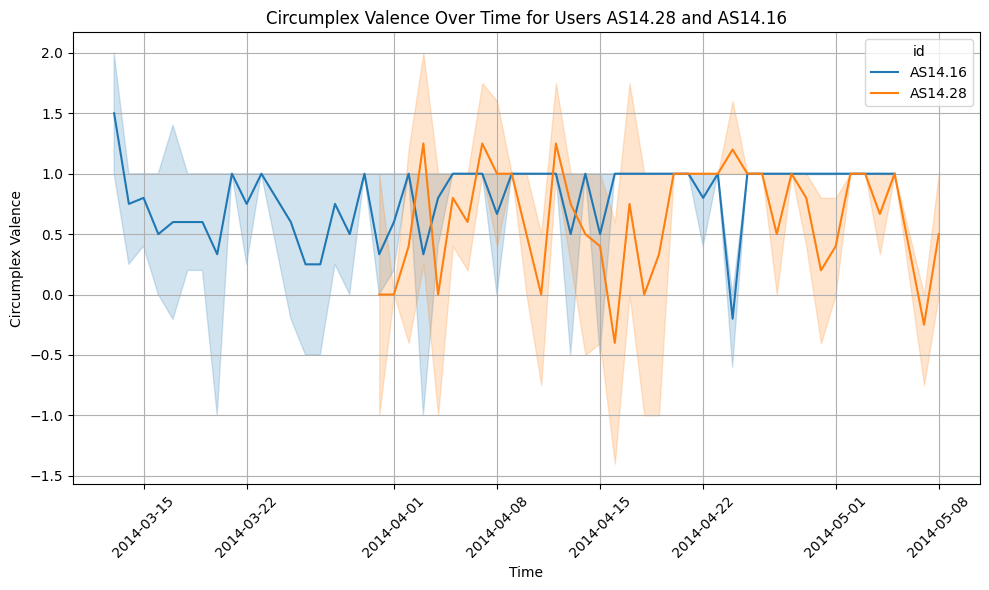

In [20]:
# create a plot showing the values for circumplex.valence of user AS14.28 and AS14.16 over time
# Filter the data for the two users and the variable
user_data = df[(df['id'].isin(['AS14.28', 'AS14.16'])) & (df['variable'] == 'circumplex.valence')]
user_data['time'] = user_data['time'].dt.date

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='value', hue='id', data=user_data)
plt.title('Circumplex Valence Over Time for Users AS14.28 and AS14.16')
plt.xlabel('Time')
plt.ylabel('Circumplex Valence')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

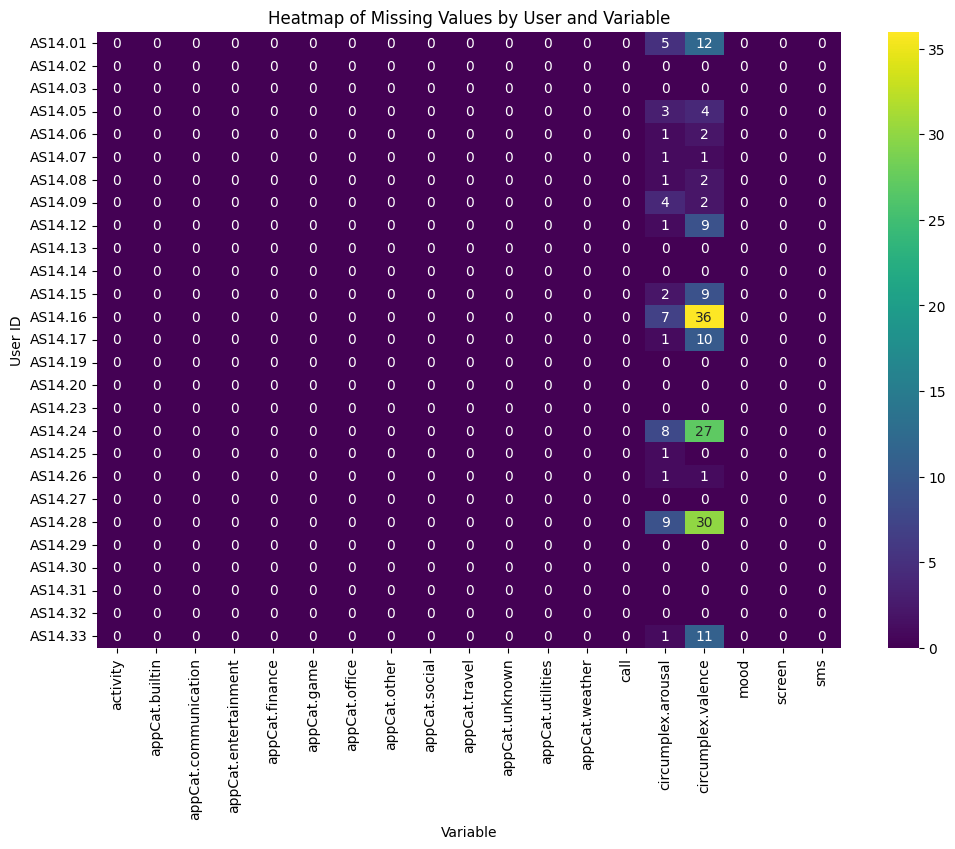

In [21]:
# Group the data by 'id' and 'variable' and count NaN values for each grouping
nan_counts = df.groupby(['id', 'variable']).apply(lambda x: x['value'].isnull().sum()).reset_index(name='Missing Values')

# Pivot the results to get a better visual representation: users on rows, variables on columns
nan_pivot = nan_counts.pivot(index='id', columns='variable', values='Missing Values').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(nan_pivot, annot=True, fmt="g", cmap='viridis')
plt.title('Heatmap of Missing Values by User and Variable')
plt.xlabel('Variable')
plt.ylabel('User ID')
plt.show()

Based on this heatmap, we see that NaN values only occur for the circumplex variables, most notably for valence. Furthermore, only a small subset of the participants have missing values.

Two common approaches for imputing missing values in time series data are:
1. Last Observation Carried Forward (LOCF): This method carries forward the last observed value.
2. Linear Interpolation: This method assumes that the change between two data points is linear and imputes the values accordingly.

We will apply both methods and then discuss which one might be more suitable.

In [28]:
# TODO: FIX IMPUTE CODE (doesnt compute stuff yet)

##### 1 - Last Observation Carried Forward (LOCF)

In [22]:
def impute_locf(df):
    # Apply LOCF imputation for each time series variable
    for var in df['variable'].unique():
        df.loc[df['variable'] == var, 'value'] = df.loc[df['variable'] == var, 'value'].fillna(method='ffill')
    return df

df_locf = impute_locf(df)

##### 2 - Linear Interpolation

In [23]:
def impute_linear_interpolation(df):
    # Apply linear interpolation for each time series variable
    for var in df['variable'].unique():
        df.loc[df['variable'] == var, 'value'] = df.loc[df['variable'] == var, 'value'].interpolate(method='linear')
    return df

df_linear = impute_linear_interpolation(df)

#### Evaluation of Imputation Methods

##### Visual Comparison

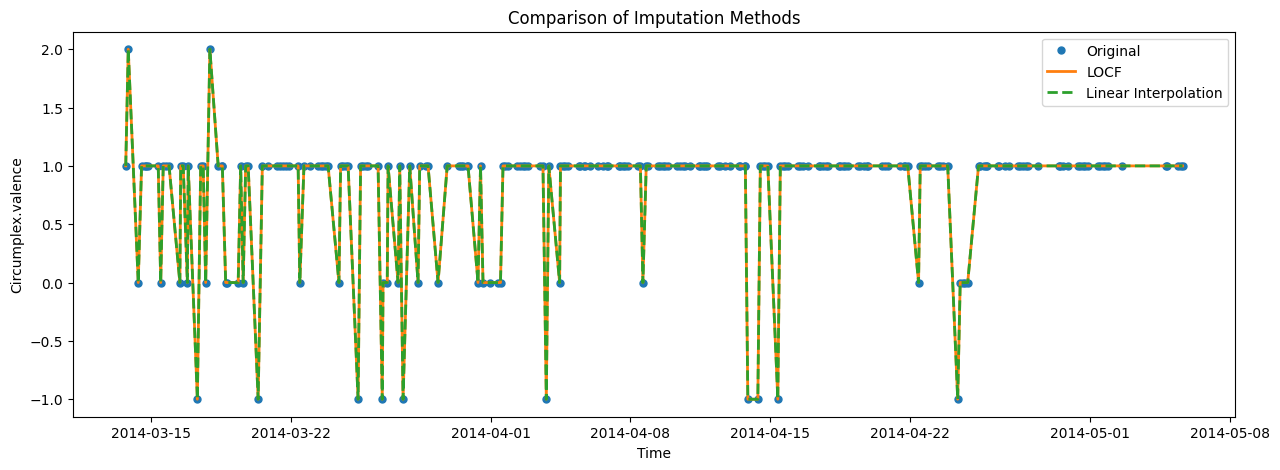

In [24]:
# Select a participant and variable for demonstration purposes
participant = 'AS14.16'
variable = 'circumplex.valence'  # Example variable

# Extract the series for the selected participant and variable
original_series = df[(df['id'] == participant) & (df['variable'] == variable)]
locf_series = df_locf[(df_locf['id'] == participant) & (df_locf['variable'] == variable)]
linear_series = df_linear[(df_linear['id'] == participant) & (df_linear['variable'] == variable)]

# Plotting the series to compare
plt.figure(figsize=(15, 5))
plt.plot(original_series['time'], original_series['value'], label='Original', marker='o', linestyle='', markersize=5)
plt.plot(locf_series['time'], locf_series['value'], label='LOCF', marker='', linestyle='-', linewidth=2)
plt.plot(linear_series['time'], linear_series['value'], label='Linear Interpolation', marker='', linestyle='--', linewidth=2)
plt.title('Comparison of Imputation Methods')
plt.xlabel('Time')
plt.ylabel(variable.capitalize())
plt.legend()
plt.show()


##### Statistical Comparison

In [25]:
# Compute summary statistics for the original and imputed datasets
summary_stats = pd.DataFrame({
    'Original': original_series['value'].describe(),
    'LOCF': locf_series['value'].describe(),
    'Linear': linear_series['value'].describe()
})

print(summary_stats)

         Original        LOCF      Linear
count  230.000000  230.000000  230.000000
mean     0.800000    0.800000    0.800000
std      0.515269    0.515269    0.515269
min     -1.000000   -1.000000   -1.000000
25%      1.000000    1.000000    1.000000
50%      1.000000    1.000000    1.000000
75%      1.000000    1.000000    1.000000
max      2.000000    2.000000    2.000000


##### Selection of Imputation Method (TODO RYAN)

Based on the evaluation, we will argue for the selected imputation method. For instance, if the data contains a strong trend or seasonality, linear interpolation may be more suitable. On the other hand, if the data are relatively stable with little variation between observations, LOCF might be the preferred choice.
We will also review scientific literature to support our choice, citing studies that have analyzed the performance of these imputation methods in similar scenarios.

For prolonged periods of missing data, neither LOCF nor linear interpolation may be appropriate as they can introduce significant bias. Instead, we can consider:
- Removing the series with prolonged gaps from the analysis.
- Using advanced imputation methods such as time series decomposition, which considers seasonality and trends.
- Applying machine learning methods like k-Nearest Neighbors or Recurrent Neural Networks to predict the missing values based on the patterns in the data.

#### Code to handle prolonged periods of missing data

Missing data can lead to a significant loss of information and can result in biased estimates if not handled properly. In our case, missing values must be addressed before moving forward with the analysis, as they may affect the accuracy of our mood prediction model.

In [26]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values' :missing_values, 'Percentage' : missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []



Depending on the variable type and the missingness pattern, we might use different imputation techniques such as mean or median imputation for numerical variables and mode imputation for categorical variables. If the data is missing completely at random (MCAR), simple imputation strategies can be sufficient. However, if there is a pattern to the missingness, we might need to consider more advanced techniques like multiple imputation or model-based methods, which take into account the relationships between variables.

Let's proceed with imputation for numerical variables that are missing values:

In [27]:
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace missing values with the mean of the column
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply imputation to each numeric variable column
for var in outlier_vars:
    df.loc[df['variable'] == var, 'value'] = mean_imputer.fit_transform(df[df['variable'] == var]['value'].values.reshape(-1,1))

# Check to confirm that there are no more missing values in the numerical columns
print(df.isnull().sum())

id          0
time        0
variable    0
value       0
dtype: int64


For the self-reported variables ('mood', 'circumplex.arousal', 'circumplex.valence', & 'activity'), we might want to use a different approach, as imputing them with the mean may not be appropriate due to the personal nature of these variables. We could consider using forward fill or backward fill to carry forward the previous value or the next value, respectively, as these scores are likely to be similar if they are recorded at frequent intervals.

In the case of 'call' and 'sms', which are boolean and primarily `1` when an event occurs, we assume that the absence of a record could be treated as a `0` (no event). However, we should carefully examine the context and determine if this assumption is valid before imputing missing values for these variables.

After imputing missing values, we will once again visualize the distribution of our variables and update our summary statistics table to ensure our data is ready for the next steps of our analysis pipeline.

Continue with the next steps, such as feature engineering, normalization, or splitting the dataset for training and testing, based on the cleaned and preprocessed data.

In [ ]:
# Code to impute missing values
# ! GPT-4 code:
import pandas as pd

# Assuming 'df' is your DataFrame and 'time' is the index if not, set it accordingly
# df.set_index('time', inplace=True)

# Linear Interpolation
df_linear = df.copy()
for var in df['variable'].unique():
    if 'time' not in df.index.names:
        df_linear.loc[df_linear['variable'] == var, 'value'] = df_linear[df_linear['variable'] == var]['value'].interpolate(method='linear')

# Simple Exponential Smoothing
df_ses = df.copy()
for var in df['variable'].unique():
    if 'time' not in df.index.names:
        df_ses.loc[df_ses['variable'] == var, 'value'] = df_ses[df_ses['variable'] == var]['value'].fillna(method='pad').ewm(alpha=0.3).mean()

# Comparison of the impact
print("Linear Interpolation Sample:")
print(df_linear[df_linear['variable'] == 'mood']['value'].head(10))

print("Exponential Smoothing Sample:")
print(df_ses[df_ses['variable'] == 'mood']['value'].head(10))

## Start on basic predicition

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, ZeroPadding1D, Masking

# NOTE: this is still little basic format for the model, will maybe have to run on Google colab?


x = df # input features
y = df[df['variable'] == 'mood'] # target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Transform data 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# Define the CNN model, three layers
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test_reshaped, y_test))

loss = model.evaluate(x_test_reshaped, y_test)
print(f'Test loss: {loss}')

predictions = model.predict(x_test_reshaped)

In [ ]:
entertainment_vars =  ['appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.social']
util_vars =  ['appCat.builtin', 'appCat.communication', 'appCat.travel', 'appCat.utilities', 'appCat.weather']
other_vars =  ['appCat.other', 'appCat.office', 'appCat.finance']

In [ ]:
for variable in entertainment_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'entertainment'
for variable in util_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'util'
for variable in other_vars:
    df.loc[df['variable'] == variable, 'variable'] = 'other'

In [ ]:
#df = df.drop([''],axis = 1)
df['time'] = pd.to_datetime(df['time'])
df_mood = df[df['variable'] == 'mood']
df_mood['time'] = df_mood['time'].dt.date
df_mood['time'] = df_mood['time'].astype("string")

In [ ]:
values = df.groupby(['id','variable',df['time'].dt.date])
first_mood_of_day = pd.DataFrame(columns=['id', 'time', 'variable', 'value'])
for group in values.groups.keys():
    group_df = values.get_group(group).reset_index()
    if(len(group_df[group_df['variable'] == 'mood']) > 0):
        first_mood_of_day.loc[len(first_mood_of_day.index)] = group_df[group_df['variable'] == 'mood'].loc[0]


In [ ]:
type(first_mood_of_day['time'][0])

In [ ]:
first_mood_of_day['time'] = pd.to_datetime(first_mood_of_day['time'], format='%d%b%Y:%H:%M:%S.%f')
first_mood_of_day['time'] = first_mood_of_day['time'].dt.date
#first_mood_of_day = first_mood_of_day.drop(['variable'],axis = 1)
first_mood_of_day = first_mood_of_day.rename(columns={"value": "mood"})
first_mood_of_day['time'] = first_mood_of_day['time'].astype('string')

In [ ]:
first_mood_of_day

create sequences with label at the end

In [ ]:
sequences = []
labels = []
for user in pd.unique(df_mood['id']):
    for day in pd.unique(df_mood['time']):
        if(len(df_mood[(df_mood['id'] == user)&(df_mood['time'] == day)]) > 0):
            new_list = list(df_mood[(df_mood['id'] == user)&(df_mood['time'] == day)]['value'])
            if(len(first_mood_of_day[(first_mood_of_day['id'] == user)&(first_mood_of_day['time'] == day)]['mood']) == 0):
                continue
            sequences.append(new_list)
            labels.append(first_mood_of_day[(first_mood_of_day['id'] == user)&(first_mood_of_day['time'] == day)]['mood'].reset_index()['mood'][0])


In [ ]:
sequences

In [ ]:
labels

In [ ]:
#define the function# https://stackoverflow.com/questions/30902558/finding-length-of-the-longest-list-in-an-irregular-list-of-lists
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

In [ ]:
max_sequence = find_max_list(sequences)
max_sequence

Add zeropadding

In [ ]:
for sequence in  sequences:
    zeros_needed = max_sequence - len(sequence)
    for i in range(zeros_needed):
        sequence.insert(0, 0)

In [ ]:
sequences

In [ ]:
labels = np.array(labels)
labels = labels.reshape(len(labels), 1)
labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(labels)
labels = encoder.transform(labels).toarray()
len(labels)

In [ ]:
labels[0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.33, random_state=42)

In [ ]:
#https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/ 
#https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

In [ ]:
print(len(X_train))
X_train

In [ ]:
print(len(y_train))
y_train

In [ ]:
# define model
model = Sequential()
model.add(Masking(mask_value=0.,
               input_shape=(1, 6)))
model.add(LSTM(100, activation='relu',
               input_shape=(1, 6)))
model.add(Dense(len(y_train[0]),activation = 'softmax' ))
model.compile(optimizer='adam', loss = ['categorical_crossentropy'], metrics=['accuracy'] )
model.build((1, 6))
model.summary()
model.fit(X_train,y_train, epochs=50)


In [ ]:
test_predictions = []
#Select last n_input values from the train data
first_eval_batch = np.array([0,0,6,6,6,7])
#reshape the data into LSTM required (#batch,#timesteps,#features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch)

pred = model.predict(current_batch)[0]
pred


In [ ]:
values = df.groupby(['id','variable',df['time'].dt.date])['value'].mean()
values = values.reset_index()
values['value'] = values['value'].astype(float)
values['time'] = values['time'].astype("string")
values

In [ ]:
columns_new = ['id','day', 'mood', 'circumplex.arousal','circumplex.valence', 'activity', 'screen', 'call', 'sms','entertainment', 'util', 'other']
feature_engineered_df = pd.DataFrame(columns = columns_new)

In [ ]:
for user in pd.unique(values['id']):
    for day in pd.unique(values['time']):
        new_values = values[(values['id'] == user)&(values['time'] == day)]
        if(new_values.empty == False):
            new_row = []
            for column  in feature_engineered_df:
                if column in pd.unique(new_values['variable']):
                    new_row.append(list(new_values.loc[new_values['variable'] == column,'value'])[0])
                else:
                    new_row.append(-10)
            new_row[0] = user
            new_row[1] = day
            feature_engineered_df.loc[len(feature_engineered_df.index)] = new_row
feature_engineered_df['day'] = pd.to_datetime(feature_engineered_df['day'])
feature_engineered_df

In [ ]:

first_mood_of_day['time'] = pd.to_datetime(first_mood_of_day['time'])

In [ ]:
final_df = pd.DataFrame()
drop_indexes = []
feature_engineered_grouped = feature_engineered_df.groupby(['id'])
for group in feature_engineered_grouped.groups.keys():
    group_df = feature_engineered_grouped.get_group(group)
    for i in range(len(group_df)):
        day = group_df.loc[group_df.index[i], 'day']
        next_day = day +  pd.DateOffset(1)
        if(len(first_mood_of_day[first_mood_of_day['time'] == next_day])> 0):
            next_day_mood = first_mood_of_day.loc[first_mood_of_day['time'] == next_day,'mood']
            group_df.loc[group_df.index[i], 'next_day_mood'] = next_day_mood[next_day_mood.index[0]]
        else:
            drop_indexes.append(group_df.index[i])
        
    final_df = pd.concat([final_df,group_df])

final_df = final_df.drop(drop_indexes)

In [ ]:
for column in final_df:
    print(f'{column}:{1-(len(final_df[final_df[column] == -10])/len(final_df))}')

In [ ]:
param_grid = { 
    'n_estimators': [100,350, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

final_df = final_df.dropna()
X = final_df.filter(items=['mood','circumplex.arousal', 'circumplex.valence' , 'activity', 'screen','entertainment','util','other','next_day_mood'])
for column in X:
    X = X[X[column] != -10]
for column in X:
    print(f'{column}:{1-(len(X[X[column] == -10])/len(X))}')
print(len(X))
labels = X['next_day_mood']
X = X.drop(['next_day_mood'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split( X,labels, test_size=0.2, random_state=0)

clf = RandomForestClassifier(max_depth= 10,random_state=0)
transformer = ColumnTransformer( [("numerical", StandardScaler(), ['circumplex.arousal', 'circumplex.valence' """, 'activity', 'screen', 'entertainment', 'util', 'other'"""]),('mood', 'passthrough',['mood'])])
pipe = Pipeline(steps=[("transformer", transformer), ("RandomForest", clf)])
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(X_train, y_train)
y_pred = CV_clf.predict(X_train)
print(f'Train_accuracy: {accuracy_score(y_train,y_pred)}')
y_pred = CV_clf.predict(X_test)
print(f'Test_accuracy: {accuracy_score(y_test,y_pred)}')

In [ ]:
print(CV_clf.best_params_)
print(sum(labels == 7)/len(labels))
plt.hist(labels)

# Old code (I think Lieve's :))

In [ ]:
# clean data by dropping NA values

cleaned_data = df[df['value'] != 'NA'].dropna()

# TODO: remove outliers for each variable and write in report why/how

print(cleaned_data)

In [ ]:
# Histogram of mood 
plt.figure(figsize=(8, 6))
plt.hist(cleaned_data[cleaned_data['variable'] == 'mood']['value'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Mood')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Boxplot of arousal 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.arousal']['value'], vert=True)
plt.title('Boxplot of arousal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of valence 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.valence']['value'], vert=True)
plt.title('Boxplot of valence')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series plot of mood
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group.loc[cleaned_data['variable'] == 'mood','time'], group.loc[cleaned_data['variable'] == 'mood','value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Mood')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Time series of activity
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group.loc[cleaned_data['variable'] == 'activity','time'], group.loc[cleaned_data['variable'] == 'activity','value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Activity')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series of activity AND mood

avg_activity = cleaned_data[cleaned_data['variable'] == 'activity'].groupby(cleaned_data['time'].dt.date)['value'].mean()
avg_mood = cleaned_data[cleaned_data['variable'] == 'mood'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Activity', color='tab:red')
ax1.plot(avg_activity.index, avg_activity.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of screen AND mood
avg_screen = cleaned_data[cleaned_data['variable'] == 'screen'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('screen', color='tab:red')
ax1.plot(avg_screen.index, avg_screen.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of utilities app and mood
avg_ut = cleaned_data[cleaned_data['variable'] == 'appCat.utilities'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Utilities', color='tab:red')
ax1.plot(avg_ut.index, avg_ut.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

In [ ]:
# convert to pandas dataframe
df = pd.DataFrame(cleaned_data, columns=["", "id", "time", "variable", "value"])

groups = df.groupby('variable')['value']

# TODO: fix statistical test so we can remove variables which are not significant

# Perform statistical tests for each variable
for var, group in groups:
    if var != 'mood':
        if len(group.unique()) > 2: 
            f_statistic, p_value = stats.f_oneway(*[group for name, group in groups])
            if p_value < 0.05:
                print(f"Variable '{var}' is significant (p-value: {p_value:.4f}, f stat: {f_statistic})")
            else:
                print(f"Variable '{var}' is not significant (p-value: {p_value:.4f}, f stat: {f_statistic})")